In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [2]:
usd = pd.read_csv('EURUSD-net.csv')
usd = usd.iloc[:, 1]
aud = pd.read_csv('EURAUD-net.csv')
aud = aud.iloc[:, 1]

In [65]:
import numpy as np
def sharpe_6m(net_pips, years):
    ret_ = [net_pips[i] - net_pips[i-1] for i in range(1, len(net_pips))]
    
    # trades/years/2 = trades per 6-month span
    n_6m = math.ceil(len(ret_)/years/2)
    
    trailing_mean = [np.mean(ret_[i-n_6m:i]) for i in range(n_6m, len(ret_))]
    trailing_std = [np.std(trailing_mean[i-n_6m:i]) for i in range(n_6m, len(trailing_mean))]
    
    # Compute 6 month trailing Sharpe
    sharpe_6m = [trailing_mean[i]/trailing_std[i] for i in range(len(trailing_std))]
    sharpe_avg = sum(sharpe_6m)/len(sharpe_6m)
    
    return sharpe_6m, sharpe_avg

In [90]:
def get_sigma_history(pips):
    dnet = [pips[i] - pips[i-1] for i in range(1, len(pips))]
    sigma_dnet = [np.std(dnet[i-50:i]) for i in range(50, len(pips))]
    for i in range(50):
        sigma_dnet.insert(0, 0)
        
    return sigma_dnet

std_adjust = [aud[i]*(1-np.std(aud[i-20:i])/(np.std(usd[i-20:i]) + np.std(aud[i-20:i]))) + 
              usd[i]*(1-np.std(usd[i-20:i])/(np.std(aud[i-20:i]) + np.std(usd[i-20:i]))) for i in range(20, min(len(aud), len(usd)))]
cumul = [aud[i] + usd[i]*(1.4/1.1) for i in range(20, min(len(aud), len(usd)))]

# Common sense variation for portfolio optimization test
# Possibly O(N^(n-N)), > optimize to O(N + 2*(n-N))
N = 20
regression_opt = [0]

usd_ret = [(usd[i] - usd[i-1])/usd[i-1] for i in range(1, len(usd))]
aud_ret = [(aud[i] - aud[i-1])/aud[i-1] for i in range(1, len(aud))]

for i in range(N+1, min(len(usd), len(aud))):
    usd_r = (usd[i-1] - usd[i-N])/np.std(usd_ret[i-N:i-1])
    aud_r = (aud[i-1] - aud[i-N])/np.std(aud_ret[i-N:i-1])
    
    if usd_r < 0:
        usd_r = 0
    if aud_r < 0:
        aud_r = 0
    
    if usd_r + aud_r > 0:
        regression_opt.append(regression_opt[-1] + (aud[i] - aud[i-1])*((aud_r/(aud_r + usd_r))) + 
                                                   (usd[i] - usd[i-1])*((usd_r/(aud_r + usd_r))))
    '''
    model = LinearRegression()
    X = np.array([i for i in range(len(aud[i-N:i]))]).reshape(-1, 1)
    y = aud[i-N:i]
    model.fit(X, y)
    aud_r2 = model.score(X, y)
    
    model = LinearRegression()
    X = np.array([i for i in range(len(usd[i-N:i]))]).reshape(-1, 1)
    y = usd[i-N:i]
    model.fit(X, y)
    usd_r2 = model.score(X, y)
    
    regression_opt.append(regression_opt[-1] + (aud[i] - aud[i-1])*(aud_r2/(aud_r2 + usd_r2)) + 
                                               (usd[i] - usd[i-1])*(usd_r2/(aud_r2 + usd_r2)))
    '''
    '''
    if usd[i-1] - usd[i-N] > 0 and aud[i-1] - aud[i-N] > 0:
        regression_opt.append(regression_opt[-1] + (aud[i] - aud[i-1])*aud_r2 + 
                                                   (usd[i] - usd[i-1])*usd_r2)
    elif usd[i-1] - usd[i-N] > 0: 
        regression_opt.append(regression_opt[-1] + (usd[i] - usd[i-1])*usd_r2 + (aud[i] - aud[i-1])/2)
    elif aud[i-1] - aud[i-N] > 0: 
        regression_opt.append(regression_opt[-1] + (aud[i] - aud[i-1])*aud_r2 + (usd[i] - usd[i-1])/2)
    '''
'''    
model = LinearRegression()
X = np.array([i for i in range(len(cumul))]).reshape(-1, 1)
y = cumul
model.fit(X, y)
print('cumul R^2\t\t', model.score(X, y))

model = LinearRegression()
X = np.array([i for i in range(len(regression_opt))]).reshape(-1, 1)
y = regression_opt
model.fit(X, y)
print('regression_opt R^2\t', model.score(X, y))
'''
print('cumul Sharpe\t\t', sharpe_6m(cumul, 2.5)[1])
print('regression_opt Sharpe\t', sharpe_6m(regression_opt, 2.5)[1])
print('cumul end\t\t', cumul[-1])
print('regression_opt end\t', regression_opt[-1])

C:\Users\Eier\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Eier\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Eier\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


cumul Sharpe		 3.43137020396
regression_opt Sharpe	 3.27628483446
cumul end		 11858.1818182
regression_opt end	 5631.69940597


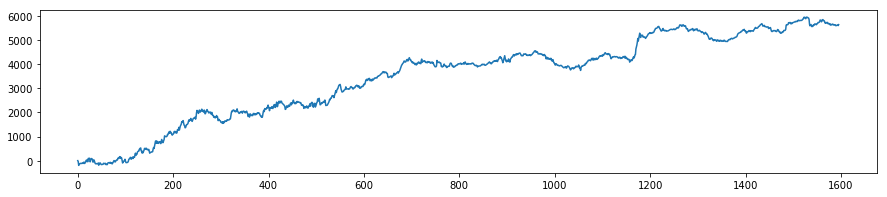

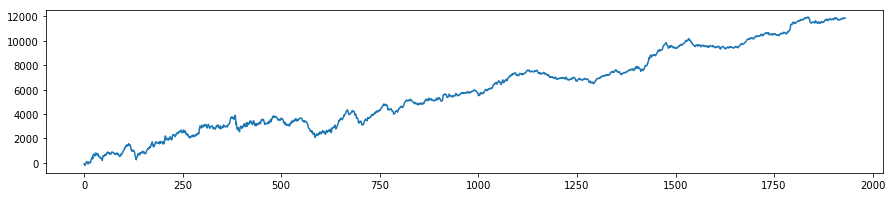

In [91]:
%matplotlib inline
boosted_net = [0]
for i in range(1, len(regression_opt)):
    boosted_net.append(boosted_net[-1] + 0.01*regression_opt[i-1]*(regression_opt[i] - regression_opt[i-1]))
boosted_cumul = [0]
for i in range(1, len(cumul)):
    boosted_cumul.append(boosted_cumul[-1] + 0.01*cumul[i-1]*(cumul[i] - cumul[i-1]))

'''
plt.figure(figsize=(15, 4))
plt.plot(boosted_net, 'r')
plt.plot(boosted_cumul, 'k')
plt.show()
'''
plt.figure(figsize=(15, 3))
plt.plot(regression_opt)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(cumul)
plt.show()